# DenseNet201 on MURA

Directly using ResNet50 from Keras: https://keras.io/applications/#resnet50

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from keras.applications.densenet import DenseNet201
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import metrics
%load_ext autotime

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

time: 665 ms


## Loading Data

Loading MURA images

In [3]:
import utils # importing from our utils functions

time: 3.79 s


In [4]:
x_train, y_train, x_test, y_test = utils.read_mura_pickle()

INFO:utils.utils:loading data/MURA-v1.1/x_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl


time: 11.9 s


We can look at the shape of the dataset:

In [5]:
x_train.shape

(36808, 256, 256)

time: 3.43 ms


In [6]:
size = x_train.shape[1]

time: 779 µs


Visually inspect an image:

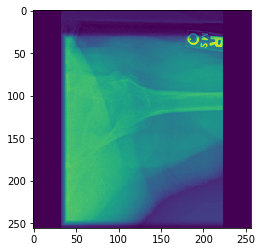

time: 144 ms


In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(x_train[0])

## Data preparation

reshape the data to `size*size*1`  (1 for channel)

In [8]:
x_train = x_train.reshape(x_train.shape[0], size, size, 1)
x_test = x_test.reshape(x_test.shape[0], size, size, 1)

time: 1.17 ms


In [9]:
x_train.shape

(36808, 256, 256, 1)

time: 1.71 ms


Convert our data type to float32 and normalize our data values to the range [0, 1].

In [10]:
x_train = utils.normalize_pixels(x_train)
x_test = utils.normalize_pixels(x_test)

time: 4.01 s


even though we have a 0-1 target, it's easier if we frame it in terms of a 2-class classification task.

In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

time: 1.36 ms


In [12]:
y_train.shape

(36808, 2)

time: 6.89 ms


In [13]:
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[1, 1.2],
    fill_mode = 'constant',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True)

time: 3.49 ms


In [14]:
datagen.fit(x_train)

time: 4.14 s


## Define model architecture

In [15]:
# declare model
with tf.device('/GPU:0'):
    model = DenseNet201(input_shape=(256, 256, 1), weights=None, classes=2)

time: 17.4 s


In [16]:
model.output_shape

(None, 2)

time: 5.87 ms


In [ ]:
model.summary()

## Compile model

We still need to define the loss and optimization method. Keras has a variety of [loss functions](https://keras.io/losses/) and out-of-the-box [optimizers](https://keras.io/optimizers/) to choose from. For this tutorial we'll use cross-entropy as loss function and [Adam](https://arxiv.org/abs/1412.6980) as our optimizer.

In [18]:
adam = optimizers.Adam(amsgrad=False) #try true later

time: 18.6 ms


In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

time: 38.8 ms


## Fitting the model

In [ ]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), 
                    steps_per_epoch = len(x_train) / 16, epochs=50, verbose=2)

In [21]:
model.save('./trained_models/1_3_densenet201_mura.h5')

time: 1min 49s


We can check how loss and accuracy change over epochs

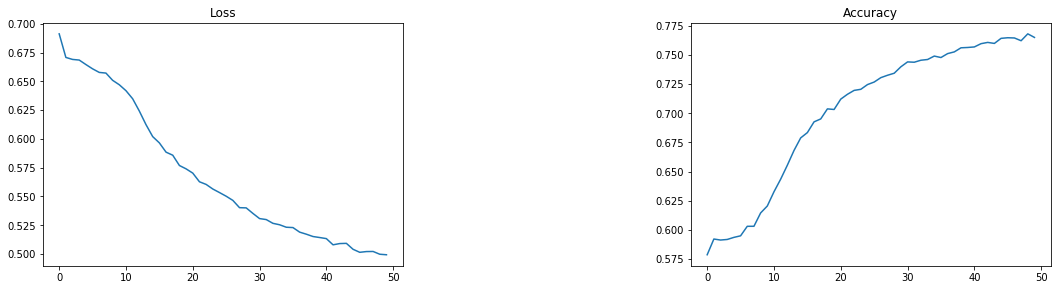

time: 292 ms


In [22]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

In [13]:
with tf.device('/GPU:1'):
    model = load_model('./trained_models/1_3_densenet201_mura.h5')

time: 17.6 s


## Evaluating our model on the test set - frist 50 epoches

### Loss and Accuracy

In [23]:
score = model.evaluate(x_test, y_test, verbose=0)

time: 28 s


In [24]:
score

[0.5923695091646389, 0.7253675319308]

time: 3.3 ms


In [32]:
# compute predicted y
y_test_hat = model.predict(x_test)

time: 23 s


In [33]:
# get actual digit labels
y_test_hat2 = y_test_hat.copy()
y_test_hat2[:, 1] = y_test_hat2[:, 1]
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(y_test_hat2, axis=1)

time: 2.61 ms


In [34]:
### Cohen's Kappa

time: 2.17 ms


In [35]:
p_observed = (true_label == pred_label).sum()/true_label.shape[0]
p_expected = sum([(true_label == i).sum() * (pred_label == i).sum() / (true_label.shape[0] ** 2) for i in range(2)])

time: 5.01 ms


In [36]:
kappa = (p_observed - p_expected) / (1 - p_expected)

time: 1.89 ms


In [37]:
kappa

0.44016180656608195

time: 2.61 ms


[[1546  121]
 [ 757  773]]


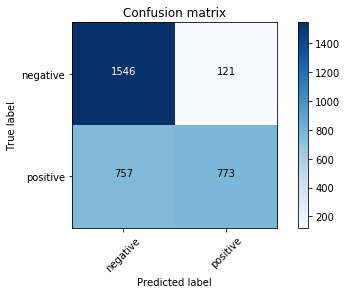

time: 180 ms


In [38]:
utils.plot_confusion_matrix(true_label, pred_label, ('negative', 'positive'))

# Epoches 50-100

In [ ]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), 
                    steps_per_epoch = len(x_train) / 16, epochs=50, verbose=2)

Epoch 1/50


In [ ]:
model.save('./trained_models/1_3_densenet201_mura_100.h5')

We can check how loss and accuracy change over epochs

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

In [13]:
with tf.device('/GPU:1'):
    model = load_model('./trained_models/1_3_densenet201_mura_100.h5')

time: 17.6 s


## Evaluating our model on the test set - frist 50 epoches

### Loss and Accuracy

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)

In [ ]:
score

In [ ]:
# compute predicted y
y_test_hat = model.predict(x_test)

In [ ]:
# get actual digit labels
y_test_hat2 = y_test_hat.copy()
y_test_hat2[:, 1] = y_test_hat2[:, 1]
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(y_test_hat2, axis=1)

In [ ]:
### Cohen's Kappa

In [ ]:
p_observed = (true_label == pred_label).sum()/true_label.shape[0]
p_expected = sum([(true_label == i).sum() * (pred_label == i).sum() / (true_label.shape[0] ** 2) for i in range(2)])

In [ ]:
kappa = (p_observed - p_expected) / (1 - p_expected)

In [ ]:
kappa

In [ ]:
utils.plot_confusion_matrix(true_label, pred_label, ('negative', 'positive'))